In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
global kn, kt, phig, alpOmega, belOmega, ntheta, radius, confining
"""
Constitutive paramters:
- Normal contact stiffness (kn)
- Contact stiffness ratio kn/kt (ratioK)
- Inter-granular friction angle (phig)
- Anisotropy of the distribution (alphaOmega)
- Principal direction of anisotropy (beltaOmega)
- Initial opening angle (alpha0)
"""
kn = 2.0e8 
kt = 0.5 * kn
phig = 30*np.pi/180
alpOmega = 0
belOmega = 0
confining = 200000 # paraThesis Guillaume in th


"""
Computation constant:
- Radius of particles (radius)
- Number of the directions of cells (ntheta)
- The limits of the directions of cells (thetaMin, thetaMax)
- localization hypothesis (locV): 'Vhexagon', 'Vboxin', 'Vboxout'
"""
radius = 1
ntheta = 360
thetaMin = 0
thetaMax = np.pi
locV = 'Vhexagon'
savepath = "/home/naa/Desktop/H_model_prediction/original_paraThesis_p200_al50_"

# Labels of grains in the hexagon
#     O1
#   O2  O6
#   O3  O5
#     O4

In [3]:
class MesoCell:
    """
    Define a class of meso cell object. Each hexagon has the following attributes:
    - its id which related to the direction of the cell(id)
    - its branch lenghts (d1, d2)
    - its opening angle (alpha)
    - the normal andnp.tangential forces of contant 1 (Fn1, Ft1) (see Nicot et al 2011)
    - the normal forces of contact 2 (Fn2)
    - its hexagon lengths(l1,l2)
    - three options of the volume (Vboxout, Vboxin, Vhexagon)
    - its direction (theta)
    - the weight of this direction (ome)
    - the Love-Weber stress multiplied by volume in the local frame (n, t) (vsignn, vsigtt)
    - the Love-Weber stress multiplied by volume in the global frame (e1, e2) (vsig11, vsig22)
    - the fabric tensor multiplied by the number of contacts in the local frame (n, t) (cfabnn, cfabtt)
    - the fabric tensor  multiplied by the number of contacts in the global frame (e1, e2) (cfab11, cfab22)
    - whether sliding exsits at the contact 1 (Sliding1)
    - whether the contact between grain1 and 2 (grains 2 and 3) is open (opening12, opening23)
    - whether the particle 2 and 4 or particle 2 and 6 are contacted (IsCont14, IsCont26)
    """

    def __init__(self, id, theta, alpha0 = 50* np.pi / 180):
        self.id = id
        self.alpha = alpha0
        self.radius = radius
        self.d1 = 2 * self.radius
        self.d2 = 2 * self.radius
        self.Fn1 = 0.0
        self.Ft1 = 0.0
        self.Fn2 = 0.0
        self.nContact = 6

        self.l1 = self.d2 + 2 * self.d1 *np.cos(self.alpha)
        self.l2 = 2 * self.d1 *np.sin(self.alpha)
        self.l10 = self.l1
        self.l20 = self.l2
        if locV == 'Vhexagon':
            Vr1 = 0; Vr2 = -np.cos(self.alpha)
        if locV == 'Vboxin':
            Vr1 = 0; Vr2 = 0
        if locV == 'Vboxout':
            Vr1 = 1; Vr2 = 1
        self.Vcell0 = (self.l1 + Vr1 * 2 * self.radius) * (self.l2 + Vr2 * 2 * self.radius)

        self.theta = theta
        self.omega = 1 / np.pi * (1 + alpOmega *np.cos(2 * (theta - belOmega))) * np.pi / ntheta # indeed it is omega*dtheta

        self.vsignn = 0.0
        self.vsigtt = 0.0

        self.vsig11 = 0.0
        self.vsig22 = 0.0
        self.vsig12 = 0.0

        self.Sliding1 = False
        self.Opening12 = False # the contact between grains1 and 2
        self.Opening23 = False # the contact between grains2 and 3
        self.IsCont14 = False
        self.IsCont26 = False
    
    def node_position(self):
        r = self.radius
        l1 = self.l1
        l2 = self.l2
        cosa =np.cos(self.alpha)
        sina =np.sin(self.alpha)
        d1 = self.d1
        d2 = self.d2
        
        x = [0,-d1*sina,-d1*sina,0,d1*sina,d1*sina]
        y = [d2/2+d1*cosa,d2/2,-d2/2,-d2/2-d1*cosa,-d2/2,d2/2]
        
        cos_theta =np.cos(self.theta)
        sin_theta =np.sin(self.theta)
            
        n = len(x)
        for i in range(n):
            x0,y0 = x[i],y[i]
            x[i] =cos_theta*x0 + sin_theta*y0
            y[i] =sin_theta*x0 + cos_theta*y0
        
        return (x,y)

    def Substrain(self, edl1, edl2):
        """
        Update cell information for given macroscopic incremental strains (soil mechanics sign convention)
        """
        G2 = 1  # 1: considering G2 in the new version of H (2021); 0: without G2 in the old version (Nicot et al 2011)

        # select the localization hypothesis
        if locV == 'Vhexagon':
            Vr1 = 0; Vr2 = -np.cos(self.alpha)
        if locV == 'Vboxin':
            Vr1 = 0; Vr2 = 0
        if locV == 'Vboxout':
            Vr1 = 1; Vr2 = 1

#         dl1 = -self.l1 * (deps11 * pow(cos(self.theta), 2.0) + deps22 * pow(sin(self.theta), 2.0) + 2 * deps12 *np.cos(self.theta) *np.sin(self.theta))
#         dl2 = -self.l2 * (deps11 * pow(sin(self.theta), 2.0) + deps22 * pow(cos(self.theta), 2.0) - 2 * deps12 *np.cos(self.theta) * sin(self.theta))

        dl1 = -edl1 * self.l10
        dl2 = -edl2 * self.l20
        # geometrical relationships
        K11 = 2.0 * np.cos(self.alpha)
        K12 = 1.0
        K13 = -2.0 * self.d1 * np.sin(self.alpha)
        K21 = 2.0 * np.sin(self.alpha)
        K22 = 0.0
        K23 = 2.0 * self.d1 * np.cos(self.alpha)

        # closure : static equilibrium, assume no sliding
        K31 = np.cos(self.alpha)
        K32 = -1.0
        K33 = (self.Fn1 * np.sin(self.alpha) - self.Ft1 *np.cos(self.alpha) - kt * self.d1 * (G2 + np.sin(self.alpha))) / kn

        # right hand side of the compatibility equation, assume no sliding
        L1 = dl1
        L2 = dl2
        L3 = 0

        K = np.array([[K11, K12, K13], 
                      [K21, K22, K23], 
                      [K31, K32, K33]])
        L = np.array([L1, L2, L3])
        solve = np.linalg.solve(K, L)  # check whether it solves K.X=L with X unknown

        dd1 = solve[0]
        dd2 = solve[1]
        dalpha = solve[2]

        dFn1 = -kn * dd1
        dFt1 = kt * (self.d1 * dalpha) 
        dFn2 = -kn * dd2

        if abs(self.Ft1 + dFt1) < abs(np.tan(phig) * (self.Fn1 - kn * dd1)):
            self.Sliding1 = False
        else:
            self.Sliding1 = True
            
            xi = -1
            if self.Ft1 > 0:
                xi = 1

            K31 =np.cos(self.alpha) + xi *np.tan(phig) * (G2 + np.sin(self.alpha))
            K33 = (self.Fn1 * np.sin(self.alpha) - self.Ft1 *np.cos(self.alpha)) / kn
            L3 = (xi * (G2 + np.sin(self.alpha)) * (np.tan(phig) * self.Fn1 - self.Ft1)) / kn 

            K = np.array([[K11, K12, K13], 
                          [K21, K22, K23], 
                          [K31, K32, K33]])
            L = np.array([L1, L2, L3])
            solve = np.linalg.solve(K, L)

            dd1 = solve[0]
            dd2 = solve[1]
            dalpha = solve[2]

            dFn1 = -kn * dd1
            dFn2 = -kn * dd2
            dFt1 = xi*np.tan(phig)*(self.Fn1+dFn1)-self.Ft1

        self.d1 += dd1
        self.d2 += dd2
        self.alpha += dalpha

        self.l1 += dl1
        self.l2 += dl2

        self.Vcell = (self.l1 + Vr2 * 2 * self.radius) * (self.l2 + Vr1 * 2 * self.radius)
        self.Fn1 += dFn1
        self.Ft1 += dFt1
        self.Fn2 += dFn2

        # Check for pathological cases
        vcorsignn, vcorsigtt = 0, 0

        if self.l1 - 2* self.radius <= 0:
            self.IsCont14 = True
            self.nContact += 1
            vcorsignn = kn * (2 * self.radius - self.l1) * self.l1
        else:
            self.IsCont14 = False


        if self.l2 - 2 * self.radius <= 0:
            self.IsCont26 = True
            self.nContact += 2
            vcorsigtt = 2 * kn * (2 * self.radius - self.l2) * self.l2
        else:
            self.IsCont26 = False


        if self.d1 > 2 * self.radius:
            #self.Fn2 = 0
            self.Fn1, self.Ft1 = 0, 0
            self.Opening12 = True
            #self.Vcell = 0
            self.nContact -= 4
        else:
            self.Opening12 = False

        if self.d2 > 2 * self.radius: #self.Fn2 < 0:
            self.Fn2 = 0
            #self.Fn1, self.Ft1 = 0, 0
            self.Opening23 = True
            #self.Vcell = 0
            self.nContact -= 2
        else:
            self.Opening23 = False

        # Update the stress (it includes pathological corrections)
        self.vsignn = 4.0 * self.Fn1 * self.d1 * pow(np.cos(self.alpha), 2.0) + 4.0 * self.Ft1 * self.d1 *np.cos(
            self.alpha) * np.sin(self.alpha) + 2.0 * self.Fn2 * self.d2 + vcorsignn
        self.vsigtt = 4.0 * self.Fn1 * self.d1 * pow(np.sin(self.alpha), 2.0) - 4.0 * self.Ft1 * self.d1 *np.cos(
            self.alpha) * np.sin(self.alpha) + vcorsigtt

        self.vsig11 = self.vsignn *np.cos(self.theta) ** 2 + self.vsigtt * np.sin(self.theta) ** 2
        self.vsig22 = self.vsignn * np.sin(self.theta) ** 2 + self.vsigtt *np.cos(self.theta) ** 2
        self.vsig12 = (self.vsignn - self.vsigtt) * np.sin(self.theta) *np.cos(self.theta)
        #output with /V

In [4]:
#Output Shape of the cell
def display(example, ball_filling = False):
    px,py = example.node_position()
    n = len(px)

    r = radius
    fig, ax = plt.subplots(figsize=(4,4))
    
    color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    for i in range(n):
        circle = plt.Circle((px[i], py[i]), r, color=color_list[i], fill=ball_filling)
        plt.gcf().gca().add_artist(circle)

    plt.axis('equal')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.show()
    
    print("number_contact: ", example.nContact)
    print("The sliding happens?", example.Sliding1)
    print('d1 = ', example.d1)
    print('d2 = ', example.d2)    
    print('l1 = ', example.l1)    
    print('l2 = ', example.l2)    
    print('N1 = ', example.Fn1)
    print('N2 = ', example.Fn2)    
    print('T1 = ', example.Ft1)    

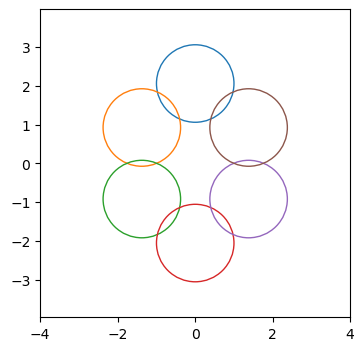

number_contact:  6
The sliding happens? False
d1 =  1.7851365262699679
d2 =  1.8462469204634493
l1 =  4.114035394871541
l2 =  2.7577599952283207
N1 =  42972694.74600641
N2 =  30750615.907310158
T1 =  1771359.8216195295


In [5]:
#a test
cell = MesoCell(1,0)
cell.Substrain(0.1,0.1)
display(cell)

For database:

Input:\
alpha0\
Matrix $\epsilon$ for $\frac{dl1}{l1}$ and $\frac{dl2}{l2}$ : 0 - 0.3 \
(l1, l2 , $\alpha$)

Output:\
d1\
d2\
alpha\
N1\
N2\
T1



In [6]:
ang_step = np.pi/180
e_step = 0.1/100
alpha0_step = np.pi/180*2

ang_list =  np.arange(0, np.pi/2 + ang_step, ang_step)
alpha0_list = np.arange(np.pi/6 + 0.1 * alpha0_step, np.pi/2 - 0.1 * alpha0_step, alpha0_step)

In [7]:
print(ang_list[-1] * 180 / np.pi)
print(alpha0_list[-1] * 180 / np.pi)

90.0
88.20000000000009


In [8]:
x = []
y = []
init_cell = []

for alpha0 in alpha0_list:
    for ang in ang_list:
        
        e_sum = 0
        e1_sum = 0
        e2_sum = 0
        js = 0
        e1_step = e_step * np.cos(ang)
        e2_step = e_step * np.sin(ang)
        cell = MesoCell (1,0,alpha0)
        
        while e_sum < 30/100:
            e_sum += e_step
            e1_sum += e1_step
            e2_sum += e2_step
            js += 1
            
            cell.Substrain(e1_step,e2_step)
            if cell.alpha/np.pi*180 < 31 or cell.alpha/np.pi*180 > 89:
                break;
            x.append([e1_sum,e2_sum,alpha0,cell.l10,cell.l20,cell.Fn1,cell.Fn2,cell.Ft1])
            y.append([cell.Fn1,cell.Fn2,cell.Ft1,cell.alpha,cell.l1,cell.l2])
                
            if js == 10:
                init_cell.append(copy.deepcopy(cell))
                js = 0

In [9]:
x = np.array(x).T
print('x shape', x.shape)
y = np.array(y).T
print('y shape', y.shape)
print(len(init_cell))

x shape (8, 746898)
y shape (6, 746898)
74538


In [10]:
for cell in init_cell:
    if cell.alpha > np.pi/2 or cell.alpha <np.pi/6:
        print(cell.alpha)

In [11]:
np.savetxt('new_input1.txt',x)
np.savetxt('new_output1.txt',y)

In [12]:
# x_read = np.loadtxt('input1.txt')
# print(x_read == x)

In [13]:
ang_step = np.pi/180 * 2
e_k = int(np.floor(1/100 / e_step))
ang_list =  np.arange(0, np.pi*2, ang_step)
print(e_k)

10


In [14]:
# take 2-3 hours don't do it again QAQ
x = []
y = []

for init_c in init_cell:
    for ang in ang_list:
        cell = copy.deepcopy(init_c)
        e1_step = e_step * np.cos(ang)
        e2_step = e_step * np.sin(ang)
        alpha = cell.alpha
        l1 = cell.l1
        l2 = cell.l2
        for i in range(e_k):
            cell.Substrain(e1_step, e2_step)
        if cell.alpha < np.pi/6 or cell.alpha > np.pi/2:
            continue;        
        x.append([e_k * e1_step,e_k * e2_step, alpha, l1, l2,cell.Fn1,cell.Fn2,cell.Ft1])
        y.append([cell.Fn1,cell.Fn2,cell.Ft1,cell.alpha,cell.l1,cell.l2])


In [15]:
x = np.array(x).T
print('x shape', x.shape)
y = np.array(y).T
print('y shape', y.shape)

x shape (8, 13367016)
y shape (6, 13367016)


In [16]:
np.savetxt('new_input2.txt',x)
np.savetxt('new_output2.txt',y)

In [17]:
x = np.loadtxt('new_input2.txt')
y = np.loadtxt('new_output2.txt')

In [18]:
x = np.array(x).T
print('x shape', x.shape)
y = np.array(y).T
print('y shape', y.shape)

x shape (13367016, 8)
y shape (13367016, 6)
